In [4]:
import pandas as pd

In [5]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/homecredit/train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/homecredit/test.csv")
lb = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/homecredit/loan_before.csv")

In [6]:
lb.columns

Index(['SK_ID_CURR', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'CREDIT_TYPE'],
      dtype='object')

In [7]:
train.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR
0,162716,0,0.0,0,1,0,101250.0,480060.0,22509.0,Unaccompanied,Working,Secondary / secondary special,House / apartment,0.009334,-18972,-2174.0,-2256,NaN,2.0,15,Kindergarten,NaN,0.665732,NaN,-139.0,1.0
1,361317,0,0.0,0,1,2,225000.0,237024.0,12231.0,Unaccompanied,Working,Higher education,House / apartment,0.010032,-11902,-1027.0,-4133,NaN,4.0,3,Business Entity Type 3,0.575699,0.535140,0.670652,-957.0,0.0
2,246925,0,1.0,0,0,0,171000.0,247675.5,26005.5,Unaccompanied,Working,Higher education,House / apartment,0.005144,-13120,-1148.0,-4340,NaN,2.0,10,Business Entity Type 3,0.092273,0.002272,0.154744,-827.0,1.0
3,294331,0,1.0,1,0,0,225000.0,180000.0,9000.0,Unaccompanied,Working,Secondary / secondary special,Rented apartment,0.018801,-10240,-1973.0,-1621,12.0,2.0,12,Trade: type 7,0.221815,0.120444,NaN,-569.0,2.0
4,152173,0,0.0,0,1,0,180000.0,337500.0,12852.0,Unaccompanied,Pensioner,Secondary / secondary special,House / apartment,0.030755,-21220,NaN,-2870,NaN,1.0,12,XNA,NaN,0.722415,0.723837,-1544.0,4.0


In [8]:
lb.head()

,SK_ID_CURR,DAYS_CREDIT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,CREDIT_TYPE
0,400486,-2413,0,180000.0,Consumer credit
1,400486,-941,0,40500.0,Credit card
2,400486,-1110,0,114727.5,Consumer credit
3,400486,-2133,0,225000.0,Consumer credit
4,400486,-391,0,142290.0,Consumer credit


# 1. 문제정의

<strong>Q1</strong> - 어떤 요소가 대출금 상환 여부에 큰 영향을 줄까? <br>
<strong>Q2</strong> - 그 요소들이 상환여부에 어떤 영향을 줄까?

# 2. 방법론

## 2.1 분석과정

이 질문에 대한 해답을 얻기 위해서 해석가능한 머신러닝 활용

<strong>프로세스</strong>

1단계 : feature engineering을 한다.<br>
2단계 : 머신러닝 모델을 만든다.<br>
3단계 : shap value를 통해 어떤 변수가 가장 큰 영향을 주는지 알아본다.<br>
4단계 : 영향을 많이 주는 5개의 변수와 대출금 상환 여부와의 관계를 살펴본다.

## 2.2 feature engineering

AMT_CREDIT에서 AMT_ANNUITY를 나누어 해당 사람이 몇개월에 걸쳐 돈을 갚아야 하는지 변수화하였다.

In [9]:
train['AMT_CREDIT_TO_ANNUITY_RATIO'] = train['AMT_CREDIT']/train['AMT_ANNUITY']
test['AMT_CREDIT_TO_ANNUITY_RATIO'] = test['AMT_CREDIT']/test['AMT_ANNUITY']

lb(이전에 대출한 정보가 기록된 데이터)를 활용해 변수생성을 시도한다.
<br>

<strong>1. groupby 후 평균(사람 id로 묶은 후 각 변수를 평균을 낸다)</strong><br>
<ul>
    <li>AMT_CREDIT_SUM(이전 대출의 금액)</li>
    <li>DAYS_CREDIT(train,test로부터 며칠 전에 이전 대출을 진행했는지)</li>
    <li>CNT_CREDIT_PROLONG(대출연장을 몇 번 했는지)</li>
</ul>
 
<strong>2. groupby 후 갯수(사람 id별로의 빈도수, 해당 사람이 이전에 대출을 몇 번 진행했는지)</strong>

In [10]:
train = pd.merge( train,lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(),on='SK_ID_CURR',how='left' )
test = pd.merge( test,lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(),on='SK_ID_CURR',how='left' )

train = pd.merge( train,lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(),on='SK_ID_CURR',how='left' )
test = pd.merge( test,lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(),on='SK_ID_CURR',how='left' )

train = pd.merge( train,lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(),on='SK_ID_CURR',how='left' )
test = pd.merge( test,lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(),on='SK_ID_CURR',how='left' )

In [11]:
train = pd.merge(train , lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0:'count'}),on='SK_ID_CURR', how='left')
test = pd.merge(test , lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns={0:'count'}),on='SK_ID_CURR', how='left')

해당 프로젝트의 목적은 모델 해석이기 때문에, 이에 방해를 주는 변수는 다 삭제한다.

<strong>제거한 변수목록</strong>
<ul>
    <li>CODE_GENDER : 범주형 변수</li>
    <li>FLAG_OWN_CAR : 범주형 변수</li>
    <li>NAME_TYPE_SUITE : 범주형 변수</li>
    <li>NAME_INCOME_TYPE : 범주형 변수</li>
    <li>NAME_EDUCATION_TYPE : 범주형 변수</li>
    <li>NAME_HOUSING_TYPE : 범주형 변수</li>
    <li>ORGANIZATION_TYPE : 범주형 변수</li>
    <li>EXT_SOURCE_1 : 변수의 의미를 정확히 모름</li>
    <li>EXT_SOURCE_2 : 변수의 의미를 정확히 모름</li>
    <li>EXT_SOURCE_3 : 변수의 의미를 정확히 모름</li>
</ul>

In [12]:
del_list = ['CODE_GENDER','FLAG_OWN_CAR','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE','ORGANIZATION_TYPE',
'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

In [13]:
train = train.drop(del_list,axis=1)
test = test.drop(del_list,axis=1)

In [14]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

## 2.3 모델링

<strong>모델링을 하기 전, 서로 상관관계가 높은 input 변수를 삭제한다.</strong>

이유 : input변수가 높은 상관성을 띌 때 shap value는 제대로 된 설명력을 발휘하지 못한다.

In [15]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

In [16]:
corr = train[input_var].corr()
corr.style.background_gradient(cmap='coolwarm')

,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count
FLAG_OWN_REALTY,1.000000,0.008244,0.003243,-0.042446,-0.001448,0.010826,-0.110930,-0.015164,0.004217,0.019393,0.014595,-0.105580,0.026066,0.090058,-0.083920,-0.002745,0.000174,-0.009790,0.008414
CNT_CHILDREN,0.008244,1.000000,0.029879,0.006465,0.023275,-0.033326,0.332123,0.068807,-0.029581,-0.010951,0.883051,-0.009661,-0.006102,-0.036431,-0.022026,0.035864,0.026285,-0.012065,0.002649
AMT_INCOME_TOTAL,0.003243,0.029879,1.000000,0.366717,0.441573,0.185047,0.066875,-0.041696,0.029519,-0.126551,0.029342,0.092505,-0.040823,0.031593,0.077303,0.241929,-0.013266,0.016117,0.116635
AMT_CREDIT,-0.042446,0.006465,0.366717,1.000000,0.770938,0.092177,-0.047089,-0.085049,0.000988,-0.111244,0.066847,0.047472,-0.070924,-0.037907,0.656337,0.135435,-0.068411,-0.000384,0.046902
AMT_ANNUITY,-0.001448,0.023275,0.441573,0.770938,1.000000,0.127204,0.017106,-0.048381,0.013662,-0.108185,0.073912,0.047113,-0.058709,0.000270,0.111694,0.128144,-0.052613,-0.005724,0.013588
REGION_POPULATION_RELATIVE,0.010826,-0.033326,0.185047,0.092177,0.127204,1.000000,-0.023276,0.013870,0.000946,-0.088270,-0.025638,0.182730,-0.051167,0.015725,0.003524,0.077984,-0.010819,0.003701,-0.034289
DAYS_BIRTH,-0.110930,0.332123,0.066875,-0.047089,0.017106,-0.023276,1.000000,0.349373,0.266852,-0.015877,0.283729,0.087200,0.080317,-0.073904,-0.097736,0.053205,0.201829,0.028239,-0.063004
DAYS_EMPLOYED,-0.015164,0.068807,-0.041696,-0.085049,-0.048381,0.013870,0.349373,1.000000,0.093421,0.014016,0.032736,0.003502,0.144221,0.003833,-0.087176,-0.018131,0.160521,0.000124,-0.148704
DAYS_ID_PUBLISH,0.004217,-0.029581,0.029519,0.000988,0.013662,0.000946,0.266852,0.093421,1.000000,0.001141,-0.025311,0.029700,0.089952,-0.039895,-0.020280,0.033384,0.188471,0.022736,-0.100673
OWN_CAR_AGE,0.019393,-0.010951,-0.126551,-0.111244,-0.108185,-0.088270,-0.015877,0.014016,0.001141,1.000000,-0.039362,-0.082672,0.013561,-0.025423,-0.059224,-0.094781,-0.006665,0.011323,-0.025711


높은 상관성을 띄는 변수는 아래와 같다.
<ul>
    <li>CNT_FAM_MEMBERS , CNT_CHILDREN</li>
    <li>AMT_CREDIT_TO_ANNUITY_RATIO , AMT_CREDIT</li>
    <li>AMT_ANNUITY , AMT_CREDIT</li>
</ul>

CNT_FAM_MEMBERS와 CNT_CHILDREN 중 타겟값과 높은 결정계수를 가진 변수는 CNT_CHILDREN이므로, CNT_FAM_MEMBERS를 삭제한다.

In [17]:
print(train['CNT_FAM_MEMBERS'].corr(train['TARGET']))
print(train['CNT_CHILDREN'].corr(train['TARGET']))

0.018876651698723722
0.025357359317615673


In [18]:
del train['CNT_FAM_MEMBERS']
del test['CNT_FAM_MEMBERS']

AMT_CREDIT_TO_ANNUITY_RATIO와 AMT_CREDIT 중 타겟값과 높은 결정계수를 가진 변수는 AMT_CREDIT_TO_ANNUITY_RATIO이므로, AMT_CREDIT를 삭제한다.

In [19]:
print(train['AMT_CREDIT_TO_ANNUITY_RATIO'].corr(train['TARGET']))
print(train['AMT_CREDIT'].corr(train['TARGET']))

-0.02474028833519016
-0.022558430849347638


In [20]:
del train['AMT_CREDIT']
del test['AMT_CREDIT']

In [21]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

In [22]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

<strong>xgboost를 활용해 모델링을 진행한다.</strong>

이유 : shap value를 활용하기 위해선 모델이 랜덤포레스트 형태의 tree형 모델이어야 한다. 이 중에서 xgboost가 속도가 빠르면서 높은 성능을 유지하므로 이를 선택

In [23]:
from xgboost import XGBClassifier

In [24]:
model = XGBClassifier(n_estimators=100, learning_rate=0.1)
model.fit(train[input_var],train['TARGET'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## 2.4 shap value 활용

In [26]:
!pip install shap

     |████████████████████████████████| 327kB 4.3MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456472 sha256=d4d429c3031af3fb48342046ba9952c692cd293b30b54969d11ecfef6f076625
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [27]:
import shap

In [28]:
shap_values = shap.TreeExplainer(model).shap_values(train[input_var])

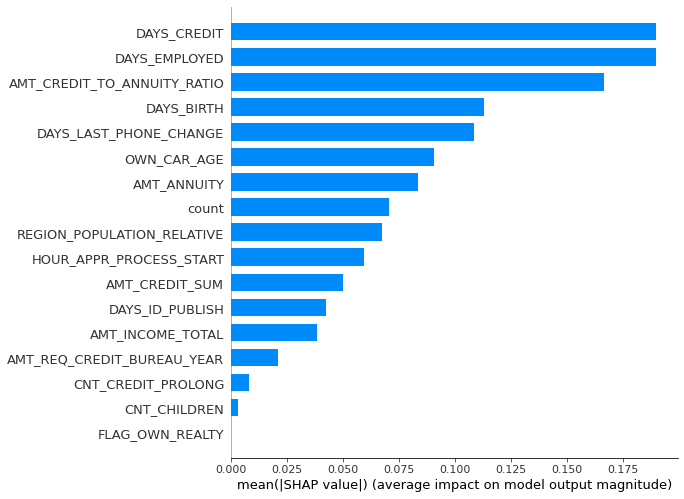

In [29]:
shap.summary_plot(shap_values, train[input_var], plot_type='bar')

시각화 결과, 타겟값에 가장 큰 영향을 미치는 상위 5가지 변수는 아래와 같다.

<ul>
    <li>AMT_CREDIT_TO_ANNUITY_RATIO</li>
    <li>DAYS_EMPLOYED</li>
    <li>DAYS_CREDIT</li>
    <li>DAYS_BIRTH</li>
    <li>DAYS_LAST_PHONE_CHANGE</li>
</ul>

## 2.5 영향을 많이 주는 5개의 변수와 상환 여부와의 관계를 알아본다.

1. AMT_CREDIT_TO_ANNUITY_RATIO

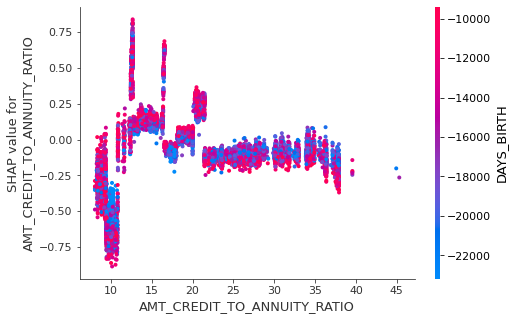

In [30]:
shap.dependence_plot('AMT_CREDIT_TO_ANNUITY_RATIO', shap_values, train[input_var])

대출 상환 기간이 12개월에서 20개월 사이일 때 비교적 상환을 잘 못한다.<br>
반면 12개월 이하, 20개월 이상일 때는 상환을 비교적 잘 한다.

2. DAYS_EMPLOYED

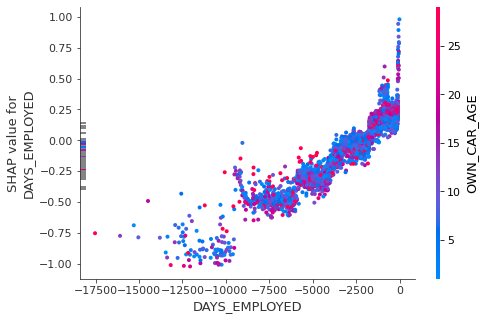

In [31]:
shap.dependence_plot('DAYS_EMPLOYED', shap_values, train[input_var])

취업한지 오래되면 오래될 수록 대출상환확률이 올라간다.<br>
대출일 기준 9000일보다 오래 전에 취업했을 때 대출상환능력이 급상승한다.

3. DAYS_CREDIT

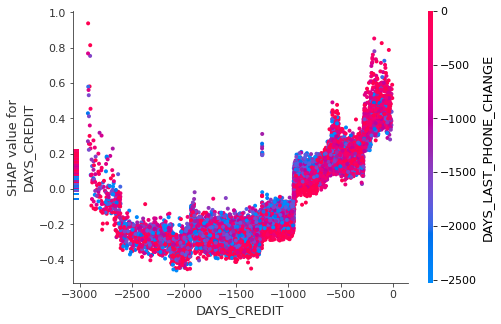

In [32]:
shap.dependence_plot('DAYS_CREDIT', shap_values, train[input_var])

DAYS_CREDIT은 -3000일부터 -2000일까지는 대출상환능력이 상승한다.<br>
그 이후부턴 하락한다.<br>

4. DAYS_BIRTH

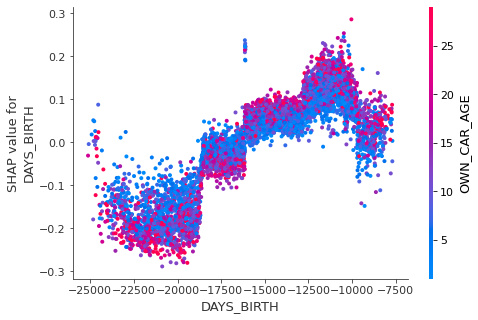

In [33]:
shap.dependence_plot('DAYS_BIRTH', shap_values, train[input_var])

나이가 많으면 많을수록 대출상환을 잘 하는 경향이 있다.

5. DAYS_LAST_PHONE_CHANGE

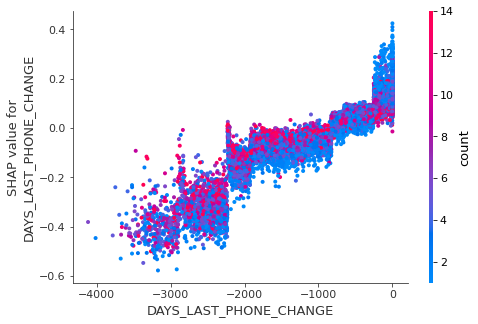

In [34]:
shap.dependence_plot('DAYS_LAST_PHONE_CHANGE', shap_values, train[input_var])

핸드폰을 오래전에 바꾸었을 수록 대출금을 상환할 가능성이 높아진다.

# 3. 결론

1. 대출 상환 기간이 상환여부에 가장 큰 영향을 준다. 해당 영향을 비선형적 관계이다(영향이 크다고 해서 인과관계가 있다고 단정짓긴 어렵다)<br><br>
2. 주택 보유 여부와 자식의 수는 대출 상환능력에 큰 영향을 미치지 않는다.<br><br>
3. 최근에 취업했을 수록, 최근에 대출을 받았을수록, 최근에 핸드폰을 바꿨을 수록, 나이가 어릴수록 대출금 상환 가능성이 낮다.<br>
(DAYS_EMPLOYED, DAYS_CREDIT, DAYS_LAST_PHONE_CHANGE, DAYS_BIRTH가 클수록 대출금 상환 가능성이 낮다)

## 3.1 마무리 시각화

In [35]:
train['DAYS_EMPLOYED'].quantile(0.75) < train['DAYS_EMPLOYED']

0        False
1        False
2        False
3        False
4        False
         ...  
19995    False
19996    False
19997     True
19998    False
19999    False
Name: DAYS_EMPLOYED, Length: 20000, dtype: bool

In [36]:
group1 = train.loc[ (train['DAYS_EMPLOYED'].quantile(0.75)< train['DAYS_EMPLOYED']) &
           (train['DAYS_CREDIT'].quantile(0.75)< train['DAYS_CREDIT']) &
           (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.75)< train['DAYS_LAST_PHONE_CHANGE']) &
           (train['DAYS_BIRTH'].quantile(0.75)< train['DAYS_BIRTH']) ]

In [37]:
group2 = train.loc[ (train['DAYS_EMPLOYED'].quantile(0.25)> train['DAYS_EMPLOYED']) &
           (train['DAYS_CREDIT'].quantile(0.25)> train['DAYS_CREDIT']) &
           (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.25)> train['DAYS_LAST_PHONE_CHANGE']) &
           (train['DAYS_BIRTH'].quantile(0.25)> train['DAYS_BIRTH']) ]

In [38]:
group1['group'] = 1
group2['group'] = 0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
full = pd.concat([group1,group2],axis=0)

In [40]:
import seaborn as sns

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


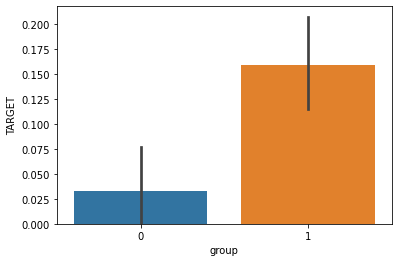

In [41]:
sns.barplot('group','TARGET',data=full)